In [1]:
#Import Dataset
dat = pd.read_csv('fin_data.csv')

<IPython.core.display.Javascript object>

In [2]:
#Importing of Packages

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Dense,Bidirectional,Conv2D,MaxPooling2D,Flatten,concatenate,GlobalAveragePooling2D,BatchNormalization,Lambda,Add,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from transformers import AutoTokenizer, TFAutoModel, TFBertModel, logging
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [3]:
#Preparation Of Data Pipelines
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset


class preparation():
    def __init__(self,df,tokenizer,bert,max_len_tweet):
        self.df=df
        self.tokenizer = tokenizer
        self.bert = bert
        self.max_len_tweet=max_len_tweet
        
        
    def tokenize(self,sentences,max_len):
        
        input_ids=[]
        attention_masks=[]
        for sent in sentences:
            bert_inp=self.tokenizer.encode_plus(sent,max_length=max_len,add_special_tokens = True,pad_to_max_length = True,return_attention_mask = True,truncation = True)
            input_ids.append(bert_inp['input_ids'])
            attention_masks.append(bert_inp['attention_mask'])

        input_ids=np.asarray(input_ids)
        attention_masks=np.array(attention_masks)
        return input_ids,attention_masks
    
    
    
    def prep_img_txt(self,input_ids, masks, path, labels):
        image = tf.io.read_file(path)
        image = tf.io.decode_image(image, channels=3,expand_animations = False)
        image = tf.cast(image, tf.float32) / 255.0 
        image = tf.image.resize(image, size=(200, 200)) 
        return {'input_ids': input_ids, 'attention_mask': masks,'images': image}, labels

    
    
    
    def prep_data_pipeline(self):
        sentences=self.df['tweet']
        input_ids,attention_masks=self.tokenize(sentences,self.max_len_tweet)
        paths =[img for i,img in enumerate(self.df['Path'])]
        labels=self.df['Target'].to_numpy()#.reshape((-1,1))
        
        dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks,paths,labels)).map(self.prep_img_txt).batch(5)
        return dataset     
        



In [4]:
train_1,test_1=train_test_split(dat, test_size=.25, random_state=42)
train=preparation(df=train_1,tokenizer=tokenizer,bert=bert,max_len_tweet=250).prep_data_pipeline()
test=preparation(df=test_1,tokenizer=tokenizer,bert=bert,max_len_tweet=250).prep_data_pipeline()

C:\Users\Lohith\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [5]:
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.BatchNormalization = tf.keras.layers.BatchNormalization()
        self.Dense1 = tf.keras.layers.Dense(115, activation='relu', kernel_regularizer=l2(0.01))
        self.Dropout = tf.keras.layers.Dropout(0.2)
        self.Dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')
    
    def call(self, inputs):
        x = self.BatchNormalization(inputs)
        x = self.Dense1(x)
        x = self.Dropout(x)
        x = self.Dense2(x)
        
        return x

In [6]:
class Rob(keras.Model):
    def __init__(self):
        super(Rob, self).__init__()
        self.GlobalMaxPool1D = tf.keras.layers.GlobalMaxPool1D()
        self.GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D()
        self.InceptionResNetV2=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200,200,3), pooling=False, classes=2)
        self.bert=TFRobertaModel.from_pretrained('roberta-base')
        #self.Flat=tf.keras.layers.Flatten()
        self.block = MLPBlock()
        self.InceptionResNetV2.trainable=False
        self.bert.trainable=False
        
    def call(self, inputs):
        text_embeddings = bert(inputs[0], attention_mask=inputs[1])[0]  #We take the first value from tuple which is the pooled_output which is the embedding hence [0]
        text_feat = self.GlobalMaxPool1D(text_embeddings)
        image_embeddings = self.InceptionResNetV2(inputs[2])
        #self.Flat=tf.keras.layers.Flatten() Can use GlobalAveragePooling2D or Flatten but when used Flatten caused overfitting issues
        #https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras#:~:text=Flatten%20accepts%20as%20input%20tensor,H*W*n_channels)%20.&text=GlobalAveragePooling2D%20accepts%20as%20input%204D%20tensor.
        image_feat = self.GlobalAveragePooling2D(image_embeddings)
        x = tf.keras.layers.concatenate([text_feat, image_feat])#Combining text and image vectors(FUSION) into a single vector
        x =self.block(x)
        return x

In [7]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = tf.keras.losses.BinaryCrossentropy()
checkpoint_filepath = r'C:\Users\Lohith\model_wt_full_albert_res.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',
    save_best_only=True)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)

seq_len=250

input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
image_inputs=tf.keras.layers.Input(shape=(200,200,3),name="images")
ins=[input_ids, mask,image_inputs]
outs = Rob()(ins)
model = tf.keras.Model(ins, outs)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()    
history=model.fit(train,validation_data=test, epochs=10,callbacks=[model_checkpoint_callback,early_stop])




Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 250)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 images (InputLayer)            [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rob (Rob)                      (None, 1)            179256775   ['input_ids[0][0]',          

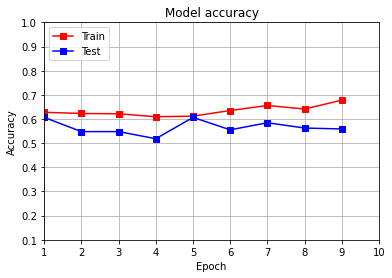

In [8]:
x=plt.plot(history.history['accuracy'],linestyle='-', marker='s', color='r')
y=plt.plot(history.history['val_accuracy'],linestyle='-', marker='s', color='b')
def plot(train,test):
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.xlim(1, 10)
    plt.ylim(0.1,1 )
    plt.grid()
    return plt.show()
plot(x,y)   

In [9]:
z=model.predict(test)
ypred=np.where(z<=0.49,0,1)
ytest=[k for i,j in test for k in j.numpy()]


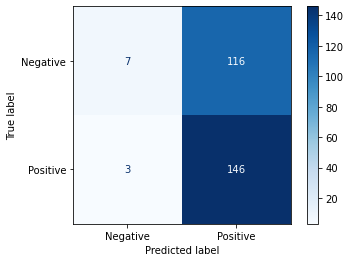

In [10]:
def confusion_mat(ytest,ypred):
    cm = confusion_matrix(ytest, ypred)
    labels = ["Negative","Positive"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues,values_format='d')
    return plt.show()

confusion_mat(ytest,ypred)

In [11]:
print("Precision: {}".format(precision_score(ytest, ypred)))
print('Recall: %.3f' % recall_score(ytest, ypred))
print('Accuracy: %.3f' % accuracy_score(ytest, ypred))
print('F1 Score: %.3f' % f1_score(ytest, ypred))


Precision: 0.5572519083969466
Recall: 0.980
Accuracy: 0.562
F1 Score: 0.710


In [12]:
target_names = ["Negative","Positive"]
print(classification_report(ytest, ypred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.70      0.06      0.11       123
    Positive       0.56      0.98      0.71       149

    accuracy                           0.56       272
   macro avg       0.63      0.52      0.41       272
weighted avg       0.62      0.56      0.44       272



In [13]:
ypred=ypred.flatten()
test_1['Pred Target']=ypred

<ipython-input-13-d6c7124f15af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['Pred Target']=ypred


In [14]:
test_1.to_csv("Predicted Tweet+Img Robert+InceptionResNet.csv")